# Watch Brand Classification with CNN and Zero-Shot CLIP

In [2]:
# Imports
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from transformers import pipeline


/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load and clean metadata
df = pd.read_csv("metadata.csv")
df = df[df["image_name"].apply(lambda x: os.path.exists(os.path.join("images", x)))]
brand_counts = df["brand"].value_counts()
valid_brands = brand_counts[brand_counts >= 2].index
df = df[df["brand"].isin(valid_brands)].reset_index(drop=True)
le = LabelEncoder()
df["brand_encoded"] = le.fit_transform(df["brand"])


In [4]:
# Train/Validation split
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["brand_encoded"], random_state=42
)
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)


In [5]:
# Number of classes
num_classes = train_df["brand_encoded"].nunique()
print("Number of classes:", num_classes)


Number of classes: 64


In [6]:
# ImageDataGenerator using OpenCV
class ImageDataGenerator(Sequence):
    def __init__(self, df, image_folder, batch_size=32, img_size=(128, 128)):
        self.df = df.reset_index(drop=True)
        self.image_folder = image_folder
        self.batch_size = batch_size
        self.img_size = img_size
        self.labels = df['brand_encoded'].values
        self.image_names = df['image_name'].values

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.image_names[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]
        images = []
        for img_name in batch_images:
            img_path = os.path.join(self.image_folder, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, self.img_size) / 255.0
                images.append(img)
        images = np.array(images)
        labels = to_categorical(batch_labels[:len(images)], num_classes=num_classes)
        return images, labels


In [7]:
# Initialize generators
train_gen = ImageDataGenerator(train_df, image_folder="images")
val_gen = ImageDataGenerator(val_df, image_folder="images")


In [8]:
# CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-27 11:15:54.733976: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [9]:
# Train the model
history = model.fit(train_gen, validation_data=val_gen, epochs=10)


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 35s 513ms/step - accuracy: 0.0386 - loss: 4.6223 - val_accuracy: 0.1627 - val_loss: 3.4441
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 350ms/step - accuracy: 0.1628 - loss: 3.4470 - val_accuracy: 0.3588 - val_loss: 2.8004
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 37s 290ms/step - accuracy: 0.3032 - loss: 2.7903 - val_accuracy: 0.4608 - val_loss: 2.2174
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 278ms/step - accuracy: 0.4089 - loss: 2.2712 - val_accuracy: 0.5431 - val_loss: 1.9480
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 277ms/step - accuracy: 0.4729 - loss: 2.0290 - val_accuracy: 0.5902 - val_loss: 1.6511
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 282ms/step - accuracy: 0.5347 - loss: 1.7739 - val_accuracy: 0.6451 - val_loss: 1.4783
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 315ms/step - accuracy: 0.5746 - loss: 1.4750 - val_accuracy: 0.6765 - val_loss: 1.3693
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 278ms/step - accuracy: 0.6153 - loss: 1.3417 - val_accu

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.7419 - loss: 1.1881
Validation Accuracy: 73.33 %


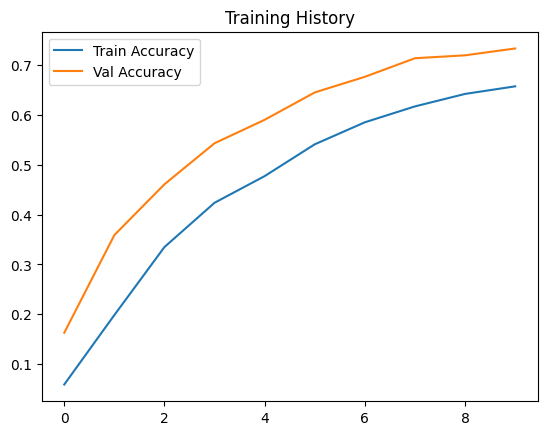

In [10]:
# Evaluate and plot
loss, acc = model.evaluate(val_gen)
print("Validation Accuracy:", round(acc * 100, 2), "%")

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Training History")
plt.show()


In [12]:
# Zero-shot classification using CLIP
zero_shot_detector = pipeline(model="openai/clip-vit-large-patch14", task="zero-shot-image-classification")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


In [13]:
# Run zero-shot on a few images
candidate_labels = train_df['brand'].unique().tolist()
sample_df = val_df.sample(5, random_state=42)

for _, row in sample_df.iterrows():
    img_path = os.path.join("images", row["image_name"])
    image = Image.open(img_path).convert("RGB")
    result = zero_shot_detector(image, candidate_labels=candidate_labels)
    print(f"True: {row['brand']}, Predicted: {result[0]['label']}, Score: {result[0]['score']:.2f}")


True: Cluse, Predicted: Cluse, Score: 1.00
True: Daniel Wellington, Predicted: Daniel Wellington, Score: 1.00
True: Swatch, Predicted: Swatch, Score: 0.98
True: VERSUS Versace, Predicted: Versace, Score: 0.57
True: Nixon, Predicted: iConnect By Timex, Score: 0.95
